# Web Scraping Job Vacancies Part 2


At the moment, I am extending the dataset from my previous web scraping project. In this phase, I intend to include major cities in Indonesia to observe the current trends and combine them into a single dataset. I generated a list of large cities programmatically to see the results. Most of the code used below is based on my earlier project, with the main addition being the inclusion of multiple cities to further analyze the effect.

## Step 1: Data Collection and Preparation


In [1]:
# Data handling and cleaning
import pandas as pd
import numpy as np

# Visualization libraries (commonly used for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Web scraping essentials
import requests
from bs4 import BeautifulSoup

In [ ]:
base_url = "https://id.jobstreet.com/id/{keyword}-jobs/in-{location}?page={page}"

jobs = []

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/114.0.0.0 Safari/537.36"
}

In [ ]:
# List of big cities in Indonesia with latitude & longitude
indonesia_cities = [
    {"city": "Jakarta", "latitude": -6.2088, "longitude": 106.8456},
    {"city": "Surabaya", "latitude": -7.2575, "longitude": 112.7521},
    {"city": "Bandung", "latitude": -6.9175, "longitude": 107.6191},
    {"city": "Medan", "latitude": 3.5952, "longitude": 98.6722},
    {"city": "Semarang", "latitude": -6.9667, "longitude": 110.4167},
    {"city": "Palembang", "latitude": -2.9761, "longitude": 104.7754},
    {"city": "Makassar", "latitude": -5.1477, "longitude": 119.4327},
    {"city": "Tangerang", "latitude": -6.1783, "longitude": 106.6319},
    {"city": "Depok", "latitude": -6.4025, "longitude": 106.7942},
    {"city": "Bekasi", "latitude": -6.2349, "longitude": 106.9896},
    {"city": "Bogor", "latitude": -6.5971, "longitude": 106.8060},
    {"city": "Malang", "latitude": -7.9839, "longitude": 112.6214},
    {"city": "Denpasar", "latitude": -8.6705, "longitude": 115.2126},
    {"city": "Batam", "latitude": 1.0456, "longitude": 104.0305},
    {"city": "Pekanbaru", "latitude": 0.5071, "longitude": 101.4478},
    {"city": "Padang", "latitude": -0.9471, "longitude": 100.4172},
    {"city": "Banjarmasin", "latitude": -3.3167, "longitude": 114.5908},
    {"city": "Pontianak", "latitude": -0.0263, "longitude": 109.3425},
    {"city": "Manado", "latitude": 1.4748, "longitude": 124.8421},
    {"city": "Yogyakarta", "latitude": -7.7956, "longitude": 110.3695}
]


In [ ]:
def create_df_job ( keyword, location, max_page, data):
  MAX_PAGES = max_page #number of page to scan
  base_url = "https://id.jobstreet.com/id/{keyword}-jobs/in-{location}?page={page}"

  for page in range(1, MAX_PAGES + 1):
    url = base_url.format(keyword=keyword, location=location, page=page)
    print("Fetching:", url)

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    soup = BeautifulSoup(response.text, "html.parser")
    jobs = soup.find_all("article")

    if not jobs:
        print("No more jobs found, stopping.")
        break

    print(f"Page {page}: {len(jobs)} jobs found")

    for job in jobs:
        title = job.find("a", {"data-automation": "jobTitle"})
        classification = job.find("span", {"data-automation": "jobClassification"})
        company = job.find("a", {"data-automation": "jobCompany"})
        job_location = job.find("a", {"data-automation": "jobLocation"})
        postings = job.find("span", {"data-automation": "jobListingDate"})
        salary = job.find("span", {"data-automation": "jobSalary"})
        job_description = job.find("span", {"data-automation": "jobShortDescription"})

        # print(f"Title: {title.get_text(strip=True) if title else None}")
        # print(f"Company: {company.get_text(strip=True) if company else None}")
        # print(f"Location: {job_location.get_text(strip=True) if job_location else None}")
        # print(f"Posting: {postings.get_text(strip=True) if postings else None}")
        # print(f"Salary: {salary.get_text(strip=True) if salary else None}")
        # print("-" * 40)

        data.append({
              "Title": title.get_text(strip=True) if title else None,
              "Classification": classification.get_text(strip=True) if classification else None,
              "Company": company.get_text(strip=True) if company else None,
              "Location": job_location.get_text(strip=True) if job_location else None,
              "Posting": postings.get_text(strip=True) if postings else None,
              "Salary": salary.get_text(strip=True) if salary else None,
              "Description": job_description.get_text(strip=True) if job_description else None
          })
  return data


In [ ]:
import re

def normalize_number(s: str) -> float:
    """
    Convert salary string with commas/dots to float safely.
    Handles '1.000.000,10' and '1,000,000.10'.
    """
    # print(s)
    if s is None:
      return None
    if not re.search(r"\d", s):
      return None

    s = s.strip()

    # Case 1: European/Indonesian format → decimals with comma
    if re.search(r",\d{1,2}$", s):
        s = s.replace(".", "")       # remove thousands separator
        s = s.replace(",", ".")      # convert decimal comma to dot

    # Case 2: US format → decimals with dot
    elif re.search(r"\.\d{1,2}$", s):
        s = s.replace(",", "")       # remove thousands separator

    # Case 3: No decimals → just strip separators
    else:
        s = s.replace(".", "").replace(",", "")

    return float(s)


In [ ]:

def parse_salary(s):


    if pd.isna(s):
        return None, None, None,None


    if "per month" in s:
        unit = "month"
    elif "per year" in s:
        unit = "year"
    elif "per hour" in s:
        unit = "hour"
    else:
        unit = None

    if "Rp" in s:
       currency = "IDR"
    elif "$" in s:
        currency = "USD"
        convert = True
    elif "SGD" in s:
        currency = "SGD"
        convert = True
    else:
        currency = None


    s_clean = (s.strip().replace("Rp", "").replace("-", "–").replace("per month", "")
    .replace("per year", "").replace("per hour", "").replace("$", "").replace("(SGD)", "")
    .replace("(USD)", "").replace("IDR", "").replace("RM", "").replace("(MYR)", "")
    )
    low = None
    high = None
    if " – " in s_clean:
      s_clean = s_clean.split(" – ")
      low = s_clean[0]
      high = s_clean[1]
    else:
      low =s_clean
      high = s_clean


    return low,high, unit, currency






In [ ]:
df_job = []
for city in indonesia_cities:
  df_job.extend(create_df_job("Any",city["city"], 80))

Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=1
Page 1: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=2
Page 2: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=3
Page 3: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=4
Page 4: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=5
Page 5: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=6
Page 6: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=7
Page 7: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=8
Page 8: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=9
Page 9: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=10
Page 10: 32 jobs found
Fetching: https://id.jobstreet.com/id/Any-jobs/in-Jakarta?page=11
Page 11: 32 jobs found
Fetching: https://id.jobstreet.com/id/A

In [ ]:
pd.DataFrame(df_job).to_csv("df_job.csv", index=False)

In [ ]:
df_job = pd.read_csv("df_job.csv")
df_job.head()

,Title,Classification,Company,Location,Posting,Salary,Description
0,"Customer Service (Jakarta), Operations, SeaBank",(Call Center & Layanan Konsumen),PT Bank Seabank Indonesia,Jakarta Selatan,1 hari yang lalu,NaN,Carry out services to customers such as delive...
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ..."
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...
3,Logistic,"(Manufaktur, Transportasi & Logistik)",NaN,Jakarta Raya,23 jam yang lalu,NaN,"Responsible of logistic from receipt, storage..."
4,Customer Service Specialist,(Call Center & Layanan Konsumen),TE Connectivity,Jakarta Raya,16 jam yang lalu,NaN,"Involves demand planning, order management, cu..."


In [ ]:
df_job[["Salary_Low","Salary_High", "Unit", "Currency"]] = df_job["Salary"].apply(lambda x: pd.Series(parse_salary(x)))
df_job.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
0,"Customer Service (Jakarta), Operations, SeaBank",(Call Center & Layanan Konsumen),PT Bank Seabank Indonesia,Jakarta Selatan,1 hari yang lalu,NaN,Carry out services to customers such as delive...,None,None,None,None
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...","6,000,000","9,000,000",month,IDR
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,"8,000,000","12,000,000",month,IDR
3,Logistic,"(Manufaktur, Transportasi & Logistik)",NaN,Jakarta Raya,23 jam yang lalu,NaN,"Responsible of logistic from receipt, storage...",None,None,None,None
4,Customer Service Specialist,(Call Center & Layanan Konsumen),TE Connectivity,Jakarta Raya,16 jam yang lalu,NaN,"Involves demand planning, order management, cu...",None,None,None,None


In [ ]:
df_job["Salary_Low"] = df_job["Salary_Low"].apply(lambda x: normalize_number(x))
df_job["Salary_High"] = df_job["Salary_High"].apply(lambda x: normalize_number(x))

In [ ]:
df_job.shape

(11933, 11)

**Amaziingg !!!**

With the maximum pages set for each city, the scraper generated over 11,000 job listings, which is significantly more than the previous dataset of only 2,560 entries. However, some cities do not have 80 pages of job postings, so the process stops earlier (for example, Medan only has 5 pages).

Note: The results may vary depending on the keyword. Currently, I am using the keyword “any” combined with city locations to generate the data. Using different keywords could produce different outcomes. Also, since job postings change over time, the dataset shown above reflects only the current snapshot of available jobs.

In [ ]:
df_job.to_csv("jobstreet_jobs_with_cities.csv", index=False, encoding="utf-8")

print("✅ Job data saved to jobstreet_jobs.csv")

✅ Job data saved to jobstreet_jobs.csv


In the final stage of data collection, I extracted 7 features from JobStreet job postings:

**Title (job title)**

**Classification (job category)**

**Company**

**Location**

**Posting (date posted)**

**Salary**

**Description**

After extraction, the data is stored in a dictionary format. To make it easier to handle, I transform this dictionary into a pandas DataFrame, which provides powerful built-in functions for cleaning, analysis, and visualization.

Finally, the processed data is saved into a CSV file for reusability and further exploration.

This workflow follows the ETL pipeline:

**E → Extract:** Collect job features via web scraping

**T → Transform:** Clean and structure the data in pandas

**L → Load:** Save the data into a reusable format (CSV)

## Step 2:Exploratory Data Analysis

In [26]:
file_path = 'https://raw.githubusercontent.com/Jasman123/Web_scraping_and_Job_Analyze/main/jobstreet_jobs_with_cities.csv'
df = pd.read_csv(file_path)
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
0,"Customer Service (Jakarta), Operations, SeaBank",(Call Center & Layanan Konsumen),PT Bank Seabank Indonesia,Jakarta Selatan,1 hari yang lalu,NaN,Carry out services to customers such as delive...,NaN,NaN,NaN,NaN
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR
3,Logistic,"(Manufaktur, Transportasi & Logistik)",NaN,Jakarta Raya,23 jam yang lalu,NaN,"Responsible of logistic from receipt, storage...",NaN,NaN,NaN,NaN
4,Customer Service Specialist,(Call Center & Layanan Konsumen),TE Connectivity,Jakarta Raya,16 jam yang lalu,NaN,"Involves demand planning, order management, cu...",NaN,NaN,NaN,NaN


In [27]:
print(f"Number of rows: {df.shape[0]}")
df = df.drop_duplicates()
print(f"Number of rows after removing duplicates: {df.shape[0]}")

Number of rows: 11933
Number of rows after removing duplicates: 5228


In [28]:
df['Classification'].value_counts().shape

(29,)

In [29]:
df.dtypes

,0
Title,object
Classification,object
Company,object
Location,object
Posting,object
Salary,object
Description,object
Salary_Low,float64
Salary_High,float64
Unit,object


In here we check if there is unproper data type as above table shows that all strings column saved in "object" while number should be stored in float or int.

**Why this step important?**

In pandas, string/text columns are usually stored as object (or string dtype in new versions).

Sometimes numeric columns (e.g. "1234", "45.6") are also stored as object because they were read in as strings (due to commas, missing values, or symbols like $).

If left uncorrected, you cannot perform mathematical operations or statistics properly.

In [30]:
df.describe()

,Salary_Low,Salary_High
count,7.890000e+02,7.890000e+02
mean,7.521840e+06,9.831156e+06
std,9.526425e+06,1.362238e+07
min,2.500000e+03,3.000000e+03
25%,4.500000e+06,5.500000e+06
50%,6.000000e+06,7.500000e+06
75%,8.000000e+06,1.000000e+07
max,2.000000e+08,3.000000e+08


In [31]:
df.isnull().sum()

,0
Title,0
Classification,0
Company,116
Location,0
Posting,0
Salary,4437
Description,1
Salary_Low,4439
Salary_High,4439
Unit,4440


In [32]:
no_salary = float(df["Salary"].isnull().sum()) / len(df) * 100
print(f"Missing salary values: {no_salary:.2f}%")

Missing salary values: 84.87%


We observed that 80.43% of the salary column is missing, indicating that the majority of job postings on JobStreet do not disclose salary information.

This missing data introduces challenges in salary-related analysis and makes it difficult to accurately estimate compensation trends. Job seekers may also find it harder to gauge fair expectations.

To address this, it is advisable to research the average salary for the target position through external sources. Factors that typically affect salary include:

1. Location


2. Industry/Segmentation


3. Years of Experience


4. Relevant Skills

If you are wondering why most companies do not provide salary information, the main reason is **competitiveness**. Many employers prefer not to disclose salaries because they do not want rival companies to know how they manage their budgeting and compensation costs.

On the other hand, providing salary information could actually increase a job seeker’s trust and improve the transparency of the job posting.

Therefore, it becomes a dilemma: companies want to stay competitive, but at the same time, salary transparency can enhance the credibility of their job advertisements.

In [33]:
no_company = df["Company"].nunique()
print(f"numbers of company: {no_company}")

numbers of company: 2218


We have a dataset containing 2,560 records and 11 features. After checking the number of companies involved, we found a total of 1.238 companies.

This means that, on average, each company has posted about **2 job** openings at the moment.

But we need to dig deeper regarding company data

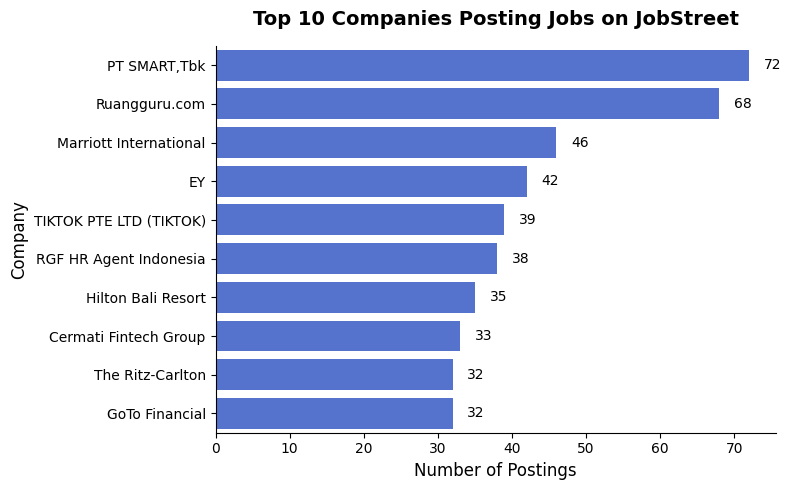

In [34]:
# Top 10 companies with most job postings
df_top10_company = df["Company"].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    y=df_top10_company.index,
    x=df_top10_company.values,
    color="royalblue"
)

# Add value labels on bars
for i, val in enumerate(df_top10_company.values):
    plt.text(val + 2, i, str(val), va='center', fontsize=10)

# Labels and title
plt.ylabel("Company", fontsize=12)
plt.xlabel("Number of Postings", fontsize=12)
plt.title("Top 10 Companies Posting Jobs on JobStreet", fontsize=14, fontweight="bold", pad=15)

sns.despine()
plt.tight_layout()
plt.show()

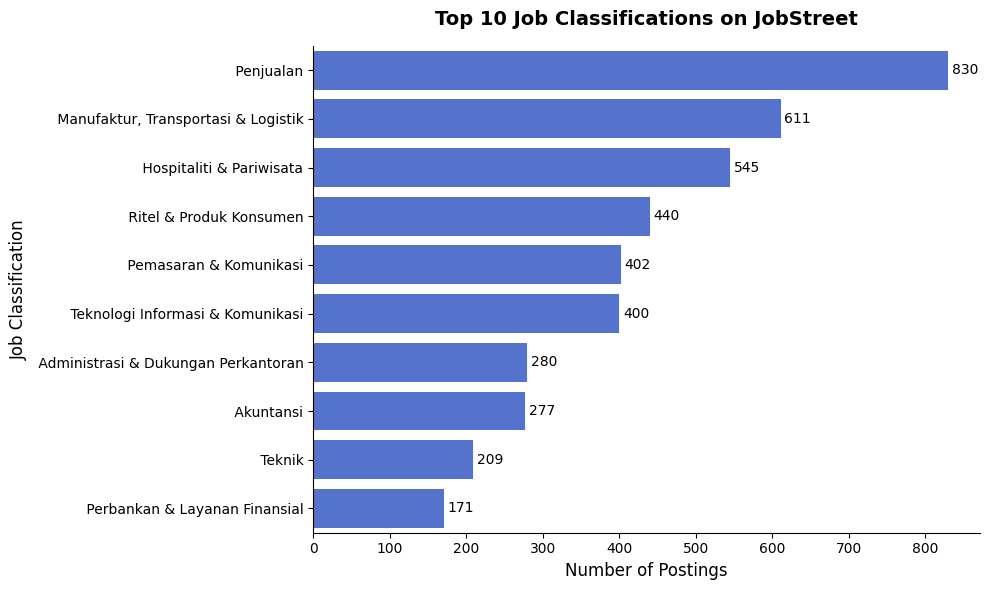

In [35]:
df_top10job = df["Classification"].value_counts().head(10).reset_index()
df_top10job.columns = [ "Classification", "Sum of Postings"]
df_top10job['Classification'] = df_top10job['Classification'].str.replace(
    r"\((.*)\)", r" \1", regex=True
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_top10job,
    y="Classification",
    x="Sum of Postings",
    color="royalblue"
)

# Add value labels
for i, val in enumerate(df_top10job["Sum of Postings"]):
    plt.text(val + 5, i, str(val), va="center", fontsize=10)

plt.ylabel("Job Classification", fontsize=12)
plt.xlabel("Number of Postings", fontsize=12)
plt.title("Top 10 Job Classifications on JobStreet", fontsize=14, fontweight="bold", pad=15)
sns.despine()
plt.tight_layout()
plt.show()

From the table above, it shows that “Penjualan” (Sales) is the top job classification among others.
However, the number of postings (106) only accounts for around 4% of the total dataset.
This indicates that there is a high variation in job classifications, and no single category dominates significantly.
Therefore, it may be necessary to merge or re-group some classifications to gain more meaningful insights.

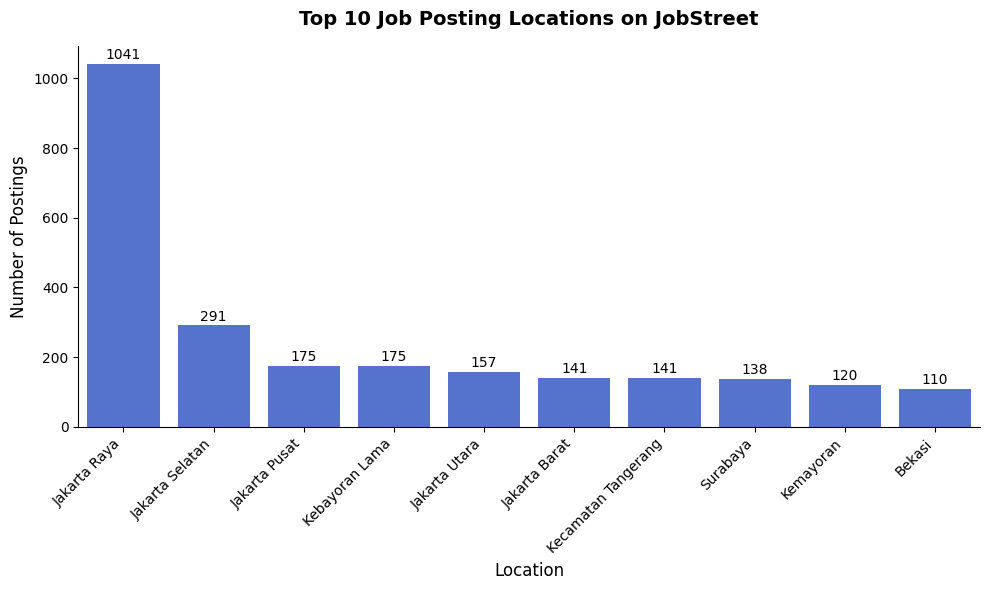

In [36]:
df_top10_location = df["Location"].value_counts().head(10)
# df_top10_location
plt.figure(figsize=(10,6))
sns.barplot(
    x=df_top10_location.index,
    y=df_top10_location.values,
    color="royalblue"  # one consistent color
)

# Add labels on top of bars
for i, val in enumerate(df_top10_location.values):
    plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=10)

plt.xlabel("Location", fontsize=12)
plt.ylabel("Number of Postings", fontsize=12)
plt.title("Top 10 Job Posting Locations on JobStreet", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()

From the graph above, we can see that most job openings in Indonesia are concentrated in Jakarta.
Even within Jakarta itself, the city is divided into five regions, yet the majority of openings are still centered there.
This explains why many people from other regions migrate to Jakarta in search of better opportunities.
With more than 10 million inhabitants, Jakarta is currently the most densely populated city in Indonesia.

However, something is noticeably missing from this dataset.
We would logically expect to see significant job postings in manufacturing hubs such as Bekasi, Bogor, Cikarang, and Karawang, since these areas are known for having large industrial estates.
This gap might be due to Jobstreet’s search algorithm.
To improve accuracy, instead of relying only on “Any” or “Indonesia” as location filters, it may be better to create a list of major cities/industrial areas and perform separate searches to build a more complete database.

I used the Folium library to visualize how dense job openings are in Jakarta.
However, it is quite difficult to perceive the exact number of openings at a glance.
To get a clearer picture, the map requires zooming in for more detail.

Moreover, the map reveals that on Sumatra Island, only Medan appears with job openings in this dataset, while other islands show no job postings at all.
This suggests that the data may be incomplete or that certain regions are underrepresented on the Jobstreet platform.

In [37]:
df = df[df['Unit']=='month']

In [38]:
max_salary = df['Salary_High'].max()
min_salary = df['Salary_Low'].min()

print(f"Maximum Salary: {max_salary}")
print(f"Minimum Salary: {min_salary}")

Maximum Salary: 130000000.0
Minimum Salary: 2500.0


In [39]:
df_max = df[df['Salary_High'] == max_salary]
df_max

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
802,Vice President of Corporate Relations,(CEO & Manajemen Umum),PT Humana International Indonesia,Jakarta Raya,6 hari yang lalu,Rp 100.000.000 – Rp 130.000.000 per month,Develop and execute strategies to build and st...,100000000.0,130000000.0,month,IDR


The value Rp 666/month is clearly unrealistic for Indonesia and is an outlier (likely a data entry error or scraping noise). Filtering it out with quantile-based trimming is a good way to clean the data.

<Axes: xlabel='Salary_Low', ylabel='Count'>

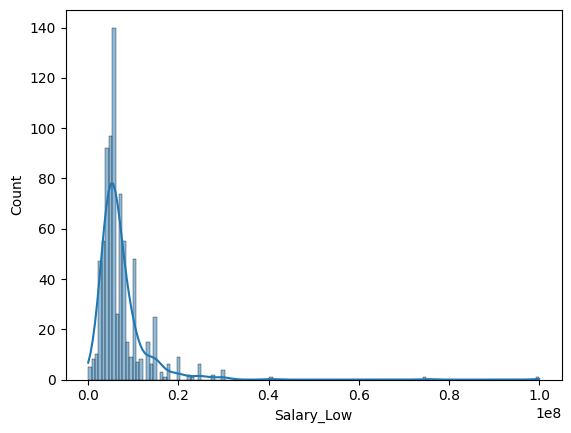

In [40]:
sns.histplot(df['Salary_Low'], kde=True)

In [41]:
q = df['Salary_Low'].quantile(0.01)
df_min = df[df['Salary_Low'] >= q]
min_salary = df_min['Salary_Low'].min()
min_salary

1500000.0

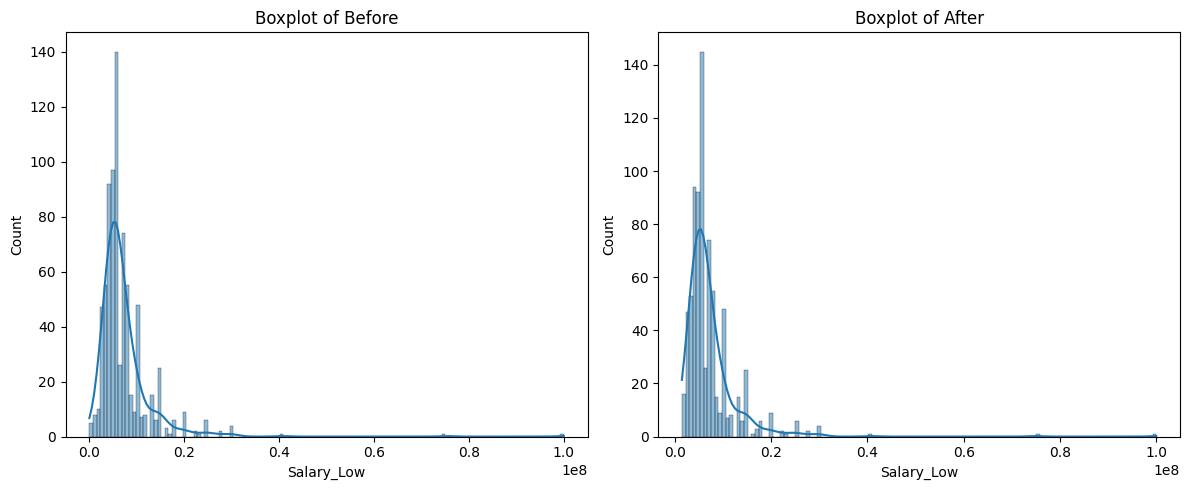

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df, x='Salary_Low', ax=ax[0], kde=True)
ax[0].set_title('Boxplot of Before')

sns.histplot(data=df_min, x='Salary_Low', ax=ax[1], kde=True)
ax[1].set_title('Boxplot of After')

plt.tight_layout()
plt.show()


After filtered out the bottom 1% (including the Rp 666/month outlier):

The histogram shifts slightly to the right → because now the lowest salary is around ≥ Rp 1,000,000/month.

This makes the distribution more realistic for Indonesia, since it’s unlikely that anyone earns below that value.

By trimming, data essentially removed unrealistic noise, so the curve better reflects actual market salaries.

In [43]:
df_min = df[df['Salary_Low'] == min_salary]
df_min

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
952,Writer,"(Periklanan, Seni & Media)",PT Aldmic Indonesia,Jakarta Barat,19 jam yang lalu,Rp 1.500.000 – Rp 1.760.000 per month,team work,1500000.0,1760000.0,month,IDR
1324,Graphic Designer Intern,(Desain & Arsitektur),Hey Coco! Creative Agency,Jakarta Barat,14 hari yang lalu,Rp 1.500.000 – Rp 2.000.000 per month,We are Hey Coco! Creative Agency based on West...,1500000.0,2000000.0,month,IDR
1736,Legal Internship,(Hukum),PT Exabytes Network Indonesia,Jakarta Selatan,29 hari yang lalu,Rp 1.500.000 per month,"As a Legal Intern, you will be an integral par...",1500000.0,1500000.0,month,IDR
4061,Writer,"(Periklanan, Seni & Media)",PT Aldmic Indonesia,Jakarta Barat,20 jam yang lalu,Rp 1.500.000 – Rp 1.760.000 per month,team work,1500000.0,1760000.0,month,IDR
11553,Costumer Services Onine,(Call Center & Layanan Konsumen),Pondok Digital,Kubu Raya,19 jam yang lalu,Rp 1.500.000 – Rp 2.200.000 per month,Bekerja sambil beramal dan berdakwah,1500000.0,2200000.0,month,IDR
11633,SOZO - APOTEKER PENANGGUNG JAWAB (MANADO) - NO...,(Kesehatan & Medis),SEVEN Retail Group,Manado,24 hari yang lalu,Rp 1.500.000 – Rp 2.000.000 per month,"Tidak bekerja di klinik secara langsung, hanya...",1500000.0,2000000.0,month,IDR


An internship or entry-level role like Sales Admin Intern is often:
Filled by students or fresh graduates starting their careers.
Paid in the range of Rp 1.5 – 2.0 million/month, which makes sense as a stipend rather than a full salary. Much more realistic than the Rp 666/month anomaly you spotted earlier.

In [44]:
df['Average_salary'] = (df['Salary_High'] + df['Salary_Low']) / 2

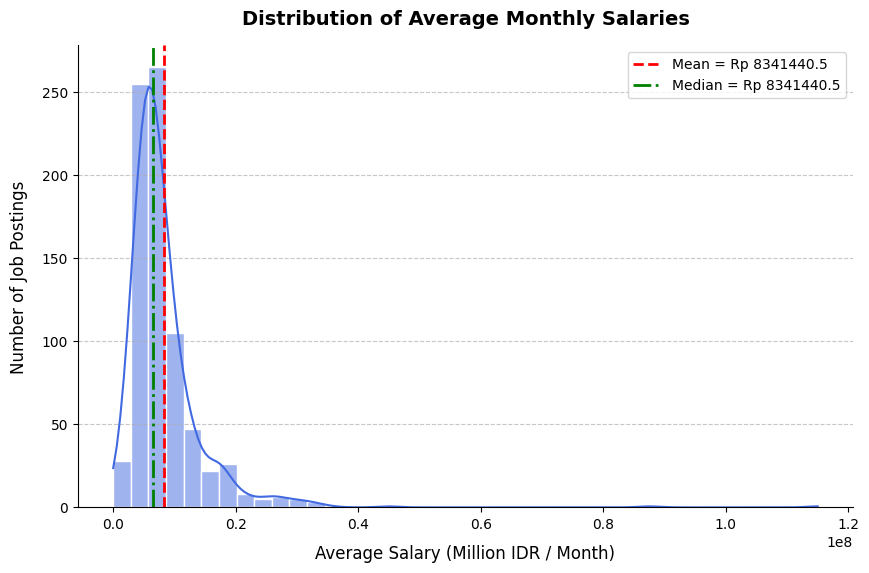

In [45]:
plt.figure(figsize=(10,6))
sns.histplot(df['Average_salary'], bins=40, kde=True, color="royalblue", edgecolor="white")
plt.xlabel("Average Salary (Million IDR / Month)", fontsize=12, labelpad=10)
plt.ylabel("Number of Job Postings", fontsize=12, labelpad=10)
plt.title("Distribution of Average Monthly Salaries", fontsize=14, fontweight="bold", pad=15)
plt.axvline(df['Average_salary'].mean(), color="red", linestyle="--", linewidth=2, label=f"Mean = Rp {df['Average_salary'].mean():.1f}")
plt.axvline(df['Average_salary'].median(), color="green", linestyle="-.", linewidth=2, label=f"Median = Rp {df['Average_salary'].mean():.1f}")

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine()
plt.show()

**🔎 Insight**



* The overall salary distribution is right-skewed, suggesting that most jobs
offer salaries below 10 million IDR.

* The mean and median (~9.3 million IDR) are close to the peak of the graph, indicating that while some outliers exist, the data remains relatively normal.

* Paying employees around 9.3 million IDR is common this year, based on both the mean and median values.

* Beyond 20 million IDR, the salary count increases significantly, likely representing positions at the senior or managerial level.

* Based on graph it shows that most frequent job lies on 5-10  Millions IDR

## Step 3 : Summary




1. Salary Disclosure: 80.43% of postings lack salary information, likely due to companies protecting compensation/bonus secrecy for competitiveness.

2. Top Hiring Companies: PT SMART, Tbk; Sheraton Kuta Bali Resort; and RGF HR Agent Indonesia.

3. Job Classification: Current categories are broad (~4% share each). A deeper, more specific classification is needed for meaningful insights.

4. Location Trends: Most openings are centered in Jakarta (the most populated city). Industrial hubs like Bekasi and Cikarang are underrepresented—possibly due to Jobstreet’s search algorithm.

5. Salary Range: Lowest posting is IDR 1.5M (Sales Admin Intern); highest is IDR 65M (Senior Sales Manager).

6. Salary Frequency: Most frequent range is IDR 5M–10M/month.


In [46]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,(Administrasi & Dukungan Perkantoran),PT AAF International Indonesia,Jakarta Utara,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"(Periklanan, Seni & Media)",Boom Digital Media,Jakarta Raya,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,(Call Center & Layanan Konsumen),redBus,Jakarta Raya,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


In [47]:
df.shape

(779, 12)

In [51]:
df['Classification'] = df['Classification'].str.replace(r"\((.*)\)", r" \1", regex=True)

In [52]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta Utara,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"Periklanan, Seni & Media",Boom Digital Media,Jakarta Raya,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,Jakarta Raya,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


In [53]:
change_name_location ={
    "%Jakarta%" : "Jakarta",
    "%Kebaryoran" : "Jakarta"

}

df['Location'] = df['Location'].map(change_name_location)

In [54]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),NaN,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,NaN,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,NaN,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"Periklanan, Seni & Media",Boom Digital Media,NaN,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,NaN,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0
